Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [61]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
from graphviz import Digraph

In [63]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [64]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), _op = '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), _op = '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh') 
    def _backward():
      self.grad += (1.0 - t**2) * out.grad 
    out._backward = _backward
    return out
    
  def exp(self): # ex.6
    e_t = math.exp(self.data)
    out = Value(e_t, (self,), 'exp')
    def _backward():
      self.grad += e_t * out.grad
    out._backward = _backward
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [65]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


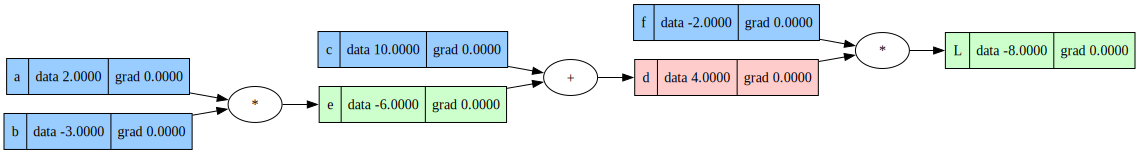

In [66]:
draw_dot(lol())

In [67]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [68]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# dL/dd = -2.0
# dL/de = -2.0
# dL/dc = -2.0
# dL/da = 6.0
# dL/db = -4.0


lol_grad()


-1.9999999999953388


In [69]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



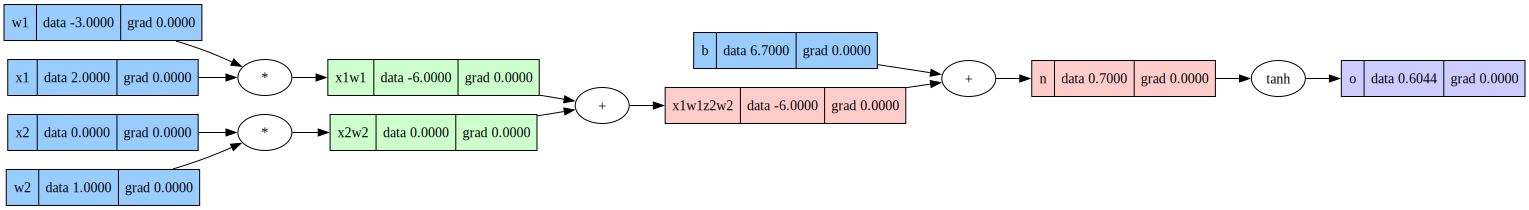

In [70]:
# o.data should be 0.6044
draw_dot(o)

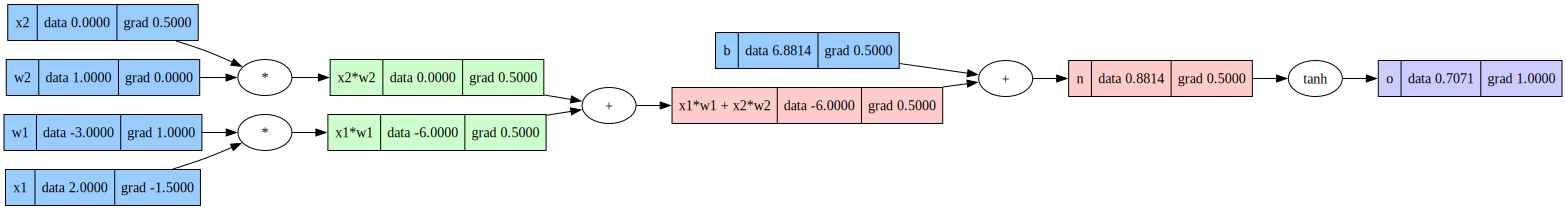

In [71]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

In [72]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?


# We use self.grad += instead of self.grad = to ensure that gradients accumulate properly during backpropagation. 
# This is needed since a Value object might contribute to multiple paths in the computation graph.

# For example, if:
# a = Value(2.0)
# b = a + a  
# b.backward()

# If we used self.grad = instead of self.grad +=, the gradient of `a` would only reflect the last computed gradient and overwrite previous contributions. 
# Since `b = a + a`, `a` appears twice in the computational graph so its gradient should be summed

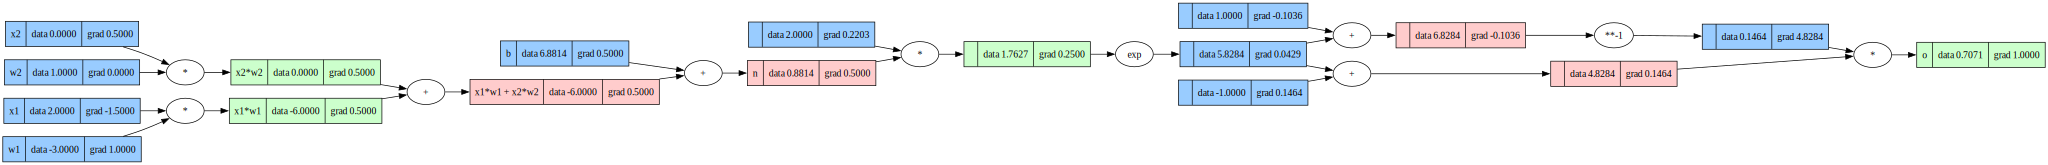

In [73]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [74]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [75]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [76]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)

    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]  # Forward pass through each neuron
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [param for neuron in self.neurons for param in neuron.w] + [neuron.b for neuron in self.neurons]


class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)  
    return x

  def parameters(self):
    return [param for layer in self.layers for param in layer.parameters()]



In [77]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6673868714117307)

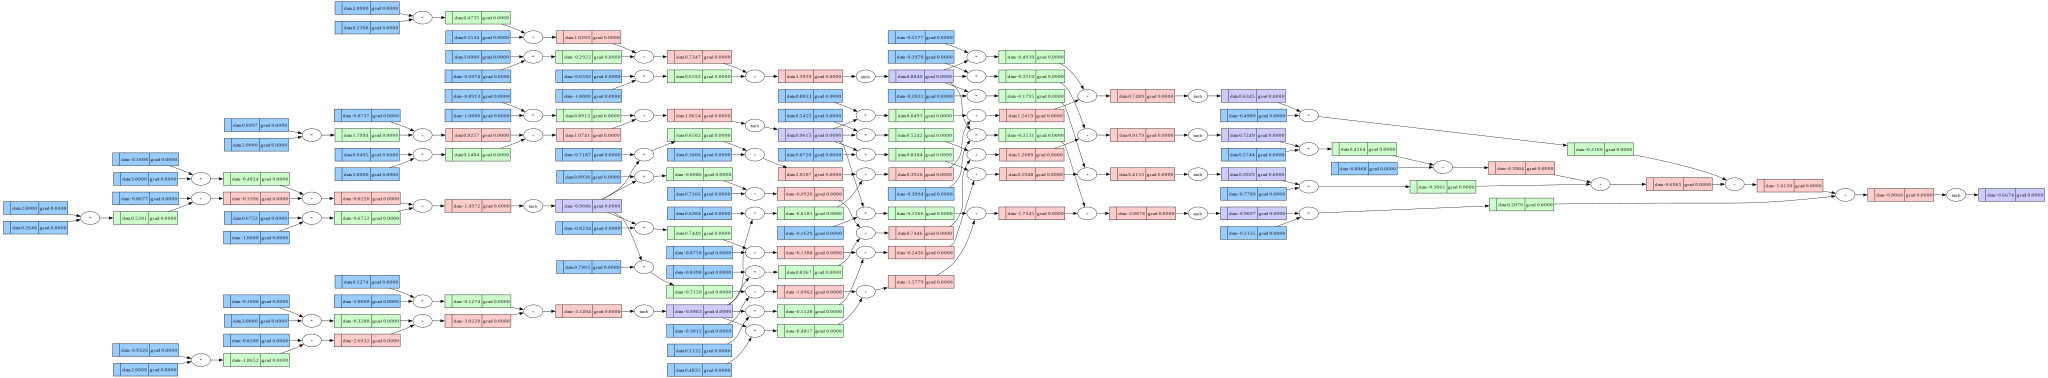

In [78]:
draw_dot(n(x))

In [79]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [80]:
len(n.parameters())

41

In [81]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6673868714117307),
 Value(data=0.4576977384463665),
 Value(data=0.6255053684605958),
 Value(data=-0.5752881163747731)]

In [82]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=10.028862028113648)

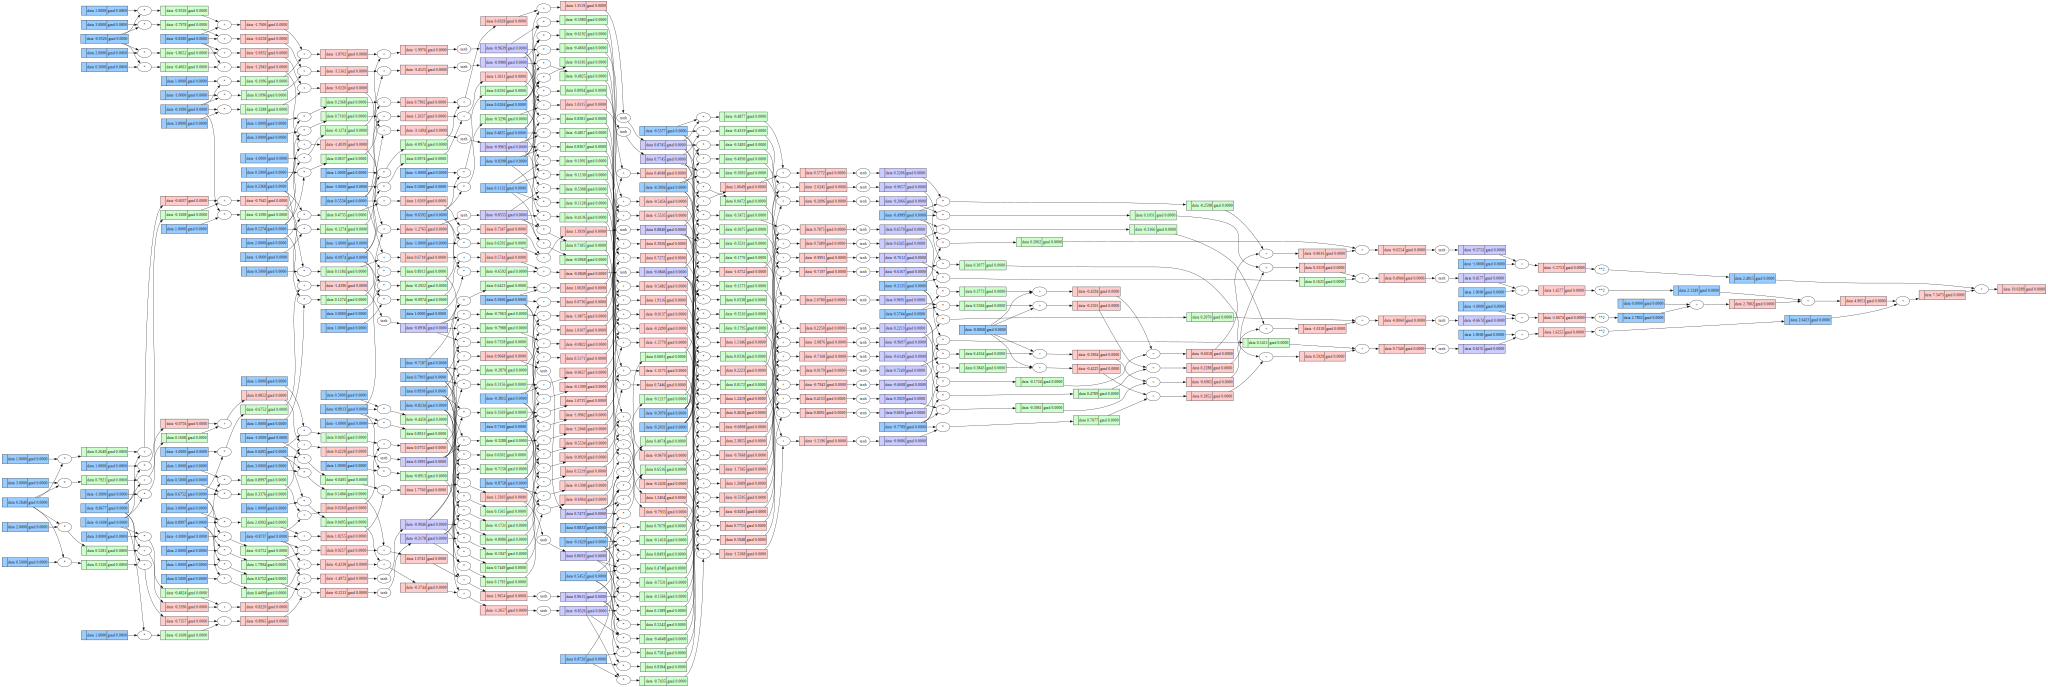

In [83]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [84]:
# Exercise 8: write a training loop
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)]) # MSE between ypred and ground-truth
    #backward pass 
    for p in n.parameters():
        p.grad = 0  # Reset gradients to zero before backpropagation
    loss.backward()  # Compute gradients
    # update
    learning_rate = 0.01
    for p in n.parameters():
        p.data -= learning_rate * p.grad  # Update parameters

    print(k, loss.data)



0 10.028862028113648
1 9.106229090599584
2 8.159336449961877
3 7.272483530938746
4 6.512854611373019
5 5.900605370125733
6 5.421900439385522
7 5.049943356443131
8 4.757010395639401
9 4.520496617996946
10 4.324253475096861
11 4.157385189335467
12 4.01255705719929
13 3.884668061776845
14 3.7699942168566944
15 3.665679332760665
16 3.5694387942975068
17 3.4793833950915802
18 3.3939091062169346
19 3.3116242995855645


In [85]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.

# We need to reset the gradients to zero at every training step so that the gradients from previous iterations aren't added to the new gradients



In [86]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?